# Andy
December 2017

This notebook uses the stacked regressions found in 
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
I have borrowed heavily from this notebook with direct copying of some
code. I want to note that Serigne references the notebooks

https://www.kaggle.com/pmarcelino/comprehensive-data-exploration-with-python
https://www.kaggle.com/juliencs/a-study-on-regression-applied-to-the-ames-dataset
https://www.kaggle.com/apapiu/regularized-linear-models

The original notebook by Serigne placed near position 100 on the leaderboard and 
this notebook got to about position 60. The prime improvements I used were 
1) Proper use of ordinal variables (see comments on map_ordinal method of Data class)
2) Feature expansion through composed features as suggestd by Juliencs
3) Feature selection by forward selection

If anyone chooses to copy this notebook and improve it I would suggest expanding
the composed features as suggested by Juliencs and adding the XGBoost and LightGBM
models back in. I would also appreciate any reference to this notebook and the 
notebooks I have referenced.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats #for some statistics
from scipy.special import boxcox1p

from sklearn import preprocessing

class Data:
    def __init__(self, train, test, cat_features, ord_features, num_features):
        self.train = train.copy()
        self.test = test.copy()
        self.cat_features = cat_features
        self.ord_features = ord_features
        self.num_features = num_features
        
        self.test_ID = test['Id']
        self.train.drop("Id", axis = 1, inplace = True)
        self.test.drop("Id", axis = 1, inplace = True)
        self.y = np.log1p(train['SalePrice'])
        (self.train).drop(['SalePrice'], axis=1, inplace=True)
        self.ntrain = train.shape[0]
        self.ntest = test.shape[0]
        self.all_data = pd.concat((self.train, self.test)).reset_index(drop=True)
        
    def massage(self):
        """ This method massages all the data. It fills in NA values and prepares
            the data for evaluation """
            
        self.fill_data()
        self.map_ordinal()
        
        self.all_data['TotalSF'] = self.all_data['TotalBsmtSF'] + self.all_data['1stFlrSF'] + self.all_data['2ndFlrSF']
        self.all_data['TotalSF-s2'] = self.all_data['TotalSF']**2
        self.all_data['TotalSF-s3'] = self.all_data['TotalSF']**3
        self.all_data['TotalSF-sq'] = np.sqrt(self.all_data['TotalSF'])
        self.num_features.extend(['TotalSF', 'TotalSF-s2', 'TotalSF-s3','TotalSF-sq'])
        
        self.all_data['OverallQual-s2'] = self.all_data['OverallQual']**2
        self.all_data['OverallQual-s3'] = self.all_data['OverallQual']**3
        self.all_data['OverallQual-sq'] = np.sqrt(self.all_data['OverallQual'])
        self.num_features.extend(['OverallQual-s2', 'OverallQual-s3', 'OverallQual-sq'])
        
        self.all_data['BsmtUnfSF-s2'] = self.all_data['BsmtUnfSF']**2
        self.all_data['BsmtUnfSF-s3'] = self.all_data['BsmtUnfSF']**3
        self.all_data['BsmtUnfSF-sq'] = np.sqrt(self.all_data['BsmtUnfSF'])
        self.num_features.extend(['BsmtUnfSF-s2', 'BsmtUnfSF-s3', 'BsmtUnfSF-sq'])
        
        self.all_data['LotArea-s2'] = self.all_data['LotArea']**2
        self.all_data['LotArea-s3'] = self.all_data['LotArea']**3
        self.all_data['LotArea-sq'] = np.sqrt(self.all_data['LotArea'])
        self.num_features.extend(['LotArea-s2', 'LotArea-s3', 'LotArea-sq'])
        
    def fill_data(self):
        """ This method cleans up the data and fills in NA values with None """
        self.all_data["PoolQC"] = self.all_data["PoolQC"].fillna("None")
        self.all_data["MiscFeature"] = self.all_data["MiscFeature"].fillna("None")
        self.all_data["Alley"] = self.all_data["Alley"].fillna("None")
        self.all_data["Fence"] = self.all_data["Fence"].fillna("None")
        self.all_data["FireplaceQu"] = self.all_data["FireplaceQu"].fillna("None")
        self.all_data["LotFrontage"] = self.all_data.groupby("Neighborhood")["LotFrontage"].transform(
                lambda x: x.fillna(x.median()))
        for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
            self.all_data[col] = self.all_data[col].fillna('None')
        for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
            self.all_data[col] = self.all_data[col].fillna(0)
        for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
            self.all_data[col] = self.all_data[col].fillna(0)
        for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
            self.all_data[col] = self.all_data[col].fillna('None')
        self.all_data["MasVnrType"] = self.all_data["MasVnrType"].fillna("None")
        self.all_data["MasVnrArea"] = self.all_data["MasVnrArea"].fillna(0)
        self.all_data['MSZoning'] = self.all_data['MSZoning'].fillna(self.all_data['MSZoning'].mode()[0])
        self.all_data = self.all_data.drop(['Utilities'], axis=1)
        self.all_data["Functional"] = self.all_data["Functional"].fillna("Typ")
        self.all_data['Electrical'] = self.all_data['Electrical'].fillna(self.all_data['Electrical'].mode()[0])
        self.all_data['KitchenQual'] = self.all_data['KitchenQual'].fillna(self.all_data['KitchenQual'].mode()[0])
        self.all_data['Exterior1st'] = self.all_data['Exterior1st'].fillna(self.all_data['Exterior1st'].mode()[0])
        self.all_data['Exterior2nd'] = self.all_data['Exterior2nd'].fillna(self.all_data['Exterior2nd'].mode()[0])
        self.all_data['SaleType'] = self.all_data['SaleType'].fillna(self.all_data['SaleType'].mode()[0])
        self.all_data['MSSubClass'] = self.all_data['MSSubClass'].fillna("None")
        self.all_data['MSSubClass'] = self.all_data['MSSubClass'].apply(str)
        self.all_data['OverallCond'] = self.all_data['OverallCond'].astype(str)
        self.all_data['YrSold'] = self.all_data['YrSold'].astype(str)
        self.all_data['MoSold'] = self.all_data['MoSold'].astype(str)
        
    def map_ordinal(self):
        """ This method maps ordinal values from text such as 'Ex' or 'Gd'. 
            It is important to do mapping by hand. If this is automated the code
            could do things alphabetically or in order of text encountered. For
            example 'Ex' would be replaced with 1 then 'Fa' would be replaced with
            2 and 'Gd' would be replaced by 3."""
        my_map = pd.Series([1, 2, 3, 4, 5], ['Ex', 'Gd', 'TA', 'Fa', 'None'])    
        self.all_data['PoolQC'] = (self.all_data['PoolQC']).map(my_map)    
        
        my_map = pd.Series([1, 2, 3, 4, 5], ['Ex', 'Gd', 'TA', 'Fa', 'Po'])
        self.all_data['KitchenQual'] = (self.all_data['KitchenQual']).map(my_map)   
        
        my_map = pd.Series([1, 2, 3, 4, 5, 6], ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'None'])
        self.all_data['FireplaceQu'] = (self.all_data['FireplaceQu']).map(my_map)
        self.all_data['GarageQual'] = (self.all_data['GarageQual']).map(my_map)
        self.all_data['GarageCond'] = (self.all_data['GarageCond']).map(my_map)
        self.all_data['ExterQual'] = (self.all_data['ExterQual']).map(my_map)
        self.all_data['ExterCond'] = (self.all_data['ExterCond']).map(my_map)
        self.all_data['HeatingQC'] = (self.all_data['HeatingQC']).map(my_map)
        self.all_data['BsmtQual'] = (self.all_data['BsmtQual']).map(my_map)
        self.all_data['BsmtCond'] = (self.all_data['BsmtCond']).map(my_map)
        
        my_map = pd.Series([1, 2, 3, 4, 5, 6, 7, 8], ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'])
        self.all_data['Functional'] = (self.all_data['Functional']).map(my_map)
        
        my_map = pd.Series([1, 2, 3, 4, 5, 6, 7], ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ','Unf','None'])
        self.all_data['BsmtFinType1'] = (self.all_data['BsmtFinType1']).map(my_map)
        self.all_data['BsmtFinType2'] = (self.all_data['BsmtFinType2']).map(my_map)
        
        my_map = pd.Series([1, 2, 3, 4, 5], ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'None'])
        self.all_data['Fence'] = (self.all_data['Fence']).map(my_map)
        
        my_map = pd.Series([1, 2, 3, 4, 5], ['Gd', 'Av', 'Mn', 'No', 'None'])
        self.all_data['BsmtExposure'] = (self.all_data['BsmtExposure']).map(my_map)
        
        my_map = pd.Series([1, 2, 3, 4], ['Fin', 'RFn', 'Unf', 'None'])
        self.all_data['GarageFinish'] = (self.all_data['GarageFinish']).map(my_map)
        
        my_map = pd.Series([1, 2, 3], ['Gtl', 'Mod', 'Sev'])
        self.all_data['LandSlope'] = (self.all_data['LandSlope']).map(my_map)
        
        my_map = pd.Series([1, 2, 3, 4], ['Reg', 'IR1', 'IR2', 'IR3'])
        self.all_data['LotShape'] = (self.all_data['LotShape']).map(my_map)
        
        my_map = pd.Series([1, 2, 3], ['Y', 'P', 'N'])
        self.all_data['PavedDrive'] = (self.all_data['PavedDrive']).map(my_map)
        
        my_map = pd.Series([1, 2, 3], ['Grvl', 'Pave', 'None'])
        self.all_data['Alley'] = (self.all_data['Alley']).map(my_map)
        
        for c in self.ord_features:
            lbl = preprocessing.LabelEncoder() 
            lbl.fit(list(self.all_data[c].values)) 
            self.all_data[c] = lbl.transform(list(self.all_data[c].values))
        
            
    def adjust_skew(self):
        """ This method goes through the numeric features (ordinal + numerical) and
        looks at thier skew. If it is skewed, a box-cox transform is applied """
                
        numeric_features = self.num_features + self.ord_features
        skewed_features = self.all_data[numeric_features].apply(lambda x: stats.skew(x.dropna())).sort_values(ascending=False)
        skewness = pd.DataFrame({'Skew' :skewed_features})

        skewness = skewness[abs(skewness) > 0.75]
        print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

        skewed_features = skewness.index
        lam = 0.15
        for feat in skewed_features:
            self.all_data[feat] = boxcox1p(self.all_data[feat], lam)
            
    def compose_sub(self, categorical_sub, ordinal_sub, numerical_sub):
        """ This function takes three lists of features and composes a dataframe
            composed of these features only"""
            
        features_sub = categorical_sub + ordinal_sub + numerical_sub
        data_sub = pd.DataFrame(columns=features_sub)
        
        for feature in features_sub:
            data_sub[feature] = self.all_data[feature]
            
        data_sub = pd.get_dummies(data_sub)
        
        return data_sub

In [12]:
color = sns.color_palette()
sns.set_style('darkgrid')

""" First inport the data. train_NAL2 is a modification of train.csv because NA
    which means No Alley is confused with Not Applicable """
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

categorical_features = ['MSZoning', 'LandContour', 'LotConfig', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
       'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation', 'Heating',
       'Electrical', 'GarageType', 'MiscFeature', 'SaleType', 'SaleCondition',
       'MSSubClass']

ordinal_features = ['FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'YrSold',
        'MoSold', 'OverallCond']

numerical_features = ['LotFrontage',   'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 
       'PoolArea', 'MiscVal',
       'OverallQual',
       'BsmtUnfSF',
       'LotArea']

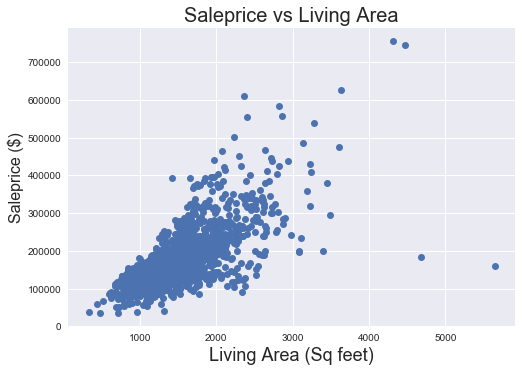

In [13]:
# do an initial plot of the data
fig = plt.figure()
plt.plot(train['GrLivArea'],train['SalePrice'],"o")
plt.title('Saleprice vs Living Area', fontsize=20)
plt.xlabel('Living Area (Sq feet)', fontsize=18)
plt.ylabel('Saleprice ($)', fontsize=16)
plt.show()

#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)


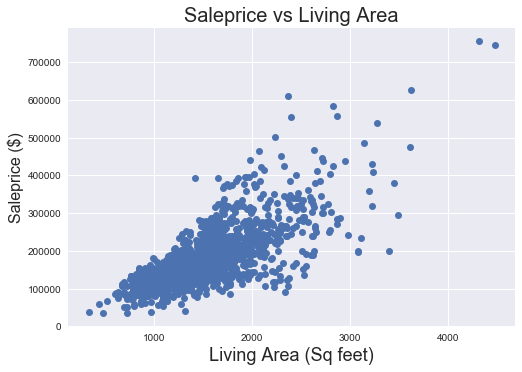

In [14]:
#And plot again to confirm outliers are gone
fig = plt.figure()
plt.plot(train['GrLivArea'],train['SalePrice'],"o")
plt.title('Saleprice vs Living Area', fontsize=20)
plt.xlabel('Living Area (Sq feet)', fontsize=18)
plt.ylabel('Saleprice ($)', fontsize=16)
plt.show()


 mu = 180932.92 and sigma = 79467.79



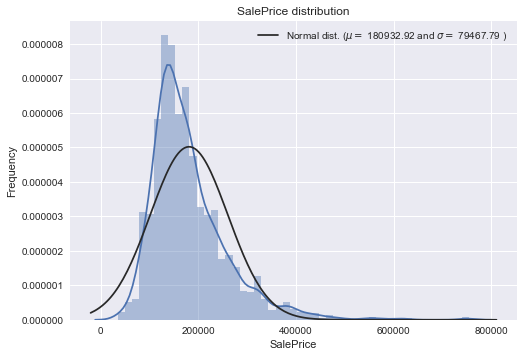

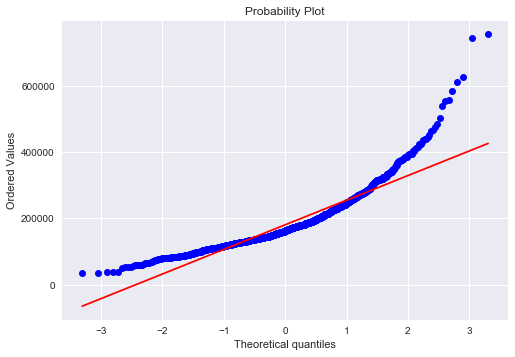

In [15]:
sns.distplot(train['SalePrice'] , fit=stats.norm);
# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

There are 70 skewed numerical features to Box Cox transform


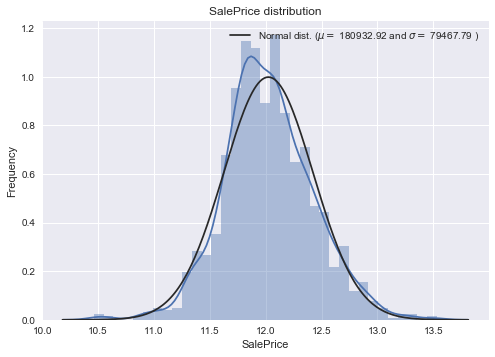

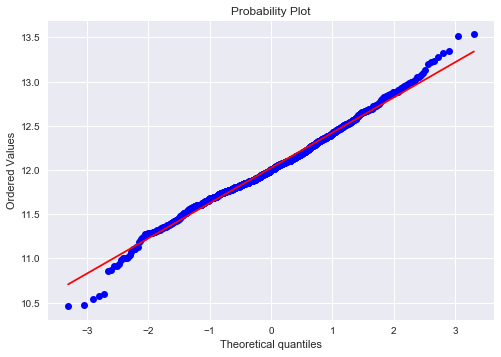

In [17]:
#Looking at the Kaggle page, we can see that results are judged by the quality
#of fit of the log of saleprice. By this metric low price houses will have the
#same impact on score as expensive houses so I will calculate it and fit it.
#I will use techniques to predict log of saleprice but then take exponent and
#report actual saleprice.

data = Data(train, test, categorical_features, ordinal_features, numerical_features)
data.massage()  
data.adjust_skew()

sns.distplot(data.y, fit=stats.norm);
(mu, sigma) = stats.norm.fit(train['SalePrice'])
#replot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(data.y, plot=plt)
plt.show()

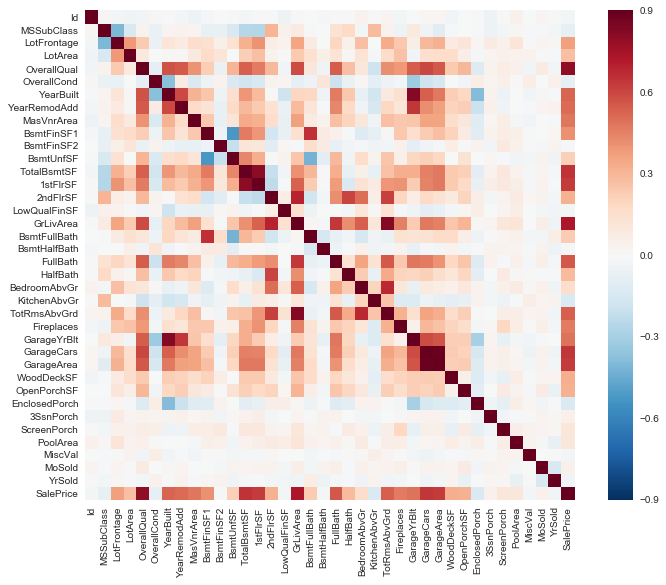

In [21]:
#Correlation map to see how features are correlated with SalePrice
corrmat = train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

In [22]:
from sklearn import linear_model
from sklearn import model_selection
from sklearn import pipeline
from sklearn import base
from sklearn import metrics

n_folds = 5

def rmsle_cv(eval_X, eval_y, model):
    kf = model_selection.KFold(n_folds, shuffle=True, random_state=42).get_n_splits(eval_X.values)
    rmse= np.sqrt(-model_selection.cross_val_score(model, eval_X.values, eval_y, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

These next two functions are used for feature selection. compose_feature_lists maintains two lists of features, those that have been used and those that are available. When it starts all features are available and no features have been used. It then calls find_best_feature that loops through the available features and returns the one that gives the best score. This returned feature is then in the used feature list and is removed from the available feature list. It calls find_best_feature with this slightly truncated available feature list and finds the feature that performs best when added to the first feature chosen. The scores will get better as more features are added until the scores reach a minimium and start to increase due to the curse of dimensionality. This tells us when to stop adding features and the optimal subset of features used for the final calculation. 

Optimal subsets could be composed for each method. Many models must be trained to compose these lists so models that are expensive to train such as GBoost are not practical. I composed one list using Lasso but if somebody wanted to improve on this they could calculate a sublist for Enet and KRR and use them in the stacking model.

In [23]:
def find_best_feature(best_cat_features, best_ord_features, best_num_features,
                      remain_cat_features, remain_ord_features, remain_num_features, 
                      data, model):
    """ This function scans through the availiable features and returns the one 
        that gives the lowest score """
        
    best_score = float("inf")
    
    for feature in remain_cat_features:
        categorical_features = best_cat_features + [feature]
        data_sub = data.compose_sub(categorical_features, best_ord_features, best_num_features)
        X = data_sub[:data.ntrain]
        y = data.y
        score = rmsle_cv(X, y, model).mean()
        if score < best_score:
            best_score = score
            best_feature = feature
            
    for feature in remain_ord_features:
        ordinal_features = best_ord_features + [feature]
        data_sub = data.compose_sub(best_cat_features, ordinal_features, best_num_features)
        X = data_sub[:data.ntrain]
        y = data.y
        score = rmsle_cv(X, y, model).mean()
        if score < best_score:
            best_score = score
            best_feature = feature
    
    for feature in remain_num_features:
        numerical_features = best_num_features + [feature]
        data_sub = data.compose_sub(best_cat_features, best_ord_features, numerical_features)
        X = data_sub[:data.ntrain]
        y = data.y
        score = rmsle_cv(X, y, model).mean()
        if score < best_score:
            best_score = score
            best_feature = feature
            
          
    return best_feature, best_score
   
    
def compose_feature_lists(cat_features, ord_features, num_features, data, model, N_features):
    """ This function does the work of composing the lists of best numerical
        features and best categorical features."""
        
    best_cat_features = []
    best_ord_features = []
    best_num_features = []
    remain_cat_features = cat_features.copy()
    remain_ord_features = ord_features.copy()
    remain_num_features = num_features.copy()

    for i in range(N_features):
        best_feature, best_score = find_best_feature(
                best_cat_features, best_ord_features, best_num_features,
                remain_cat_features, remain_ord_features, remain_num_features,
                data, model)

        if best_feature in remain_cat_features:
            remain_cat_features.remove(best_feature)
            best_cat_features.append(best_feature)
            print ("best feature is a categorical feature", best_feature, best_score, i)
            
        if best_feature in remain_ord_features:
            remain_ord_features.remove(best_feature)
            best_ord_features.append(best_feature)
            print ("best feature is a ordinal feature", best_feature, best_score, i)
            
        if best_feature in remain_num_features:
            remain_num_features.remove(best_feature)
            best_num_features.append(best_feature)
            print ("best feature is a numerical feature", best_feature, best_score, i)
    
        
            
    return best_cat_features, best_ord_features, best_num_features

In [24]:
lasso = pipeline.make_pipeline(preprocessing.RobustScaler(), linear_model.Lasso(alpha =0.0005, random_state=1))

best_cat_features, best_ord_features, best_num_features = compose_feature_lists(
        categorical_features, ordinal_features, numerical_features, data, lasso, 50)

data_sub = data.compose_sub(best_cat_features, best_ord_features, best_num_features)

X = data_sub[:data.ntrain]
X_test = data_sub[data.ntrain:]
y = data.y
score = rmsle_cv(X, y, lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

lasso.fit(X.values, y)
lasso_pred = np.expm1(lasso.predict(X_test.values))

best feature is a numerical feature TotalSF-s3 0.224256502609 0
best feature is a numerical feature OverallQual-s3 0.176503880429 1
best feature is a categorical feature Neighborhood 0.156895723293 2
best feature is a ordinal feature OverallCond 0.148465111653 3
best feature is a numerical feature BsmtUnfSF-s3 0.140887006265 4
best feature is a numerical feature YearBuilt 0.135025227943 5
best feature is a numerical feature LotArea-sq 0.128251977304 6
best feature is a numerical feature GarageCars 0.125402715218 7
best feature is a categorical feature MSZoning 0.123029657365 8
best feature is a ordinal feature KitchenQual 0.120709901754 9
best feature is a categorical feature SaleCondition 0.118744823702 10
best feature is a categorical feature MSSubClass 0.117285496081 11
best feature is a ordinal feature Functional 0.115924204155 12
best feature is a numerical feature GrLivArea 0.114410185711 13
best feature is a ordinal feature BsmtExposure 0.113106946901 14
best feature is a catego

C:\apps\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


best feature is a numerical feature LotArea-s2 0.106182864799 49

Lasso score: 0.1062 (0.0052)



In [26]:
ENet = pipeline.make_pipeline(preprocessing.RobustScaler(),linear_model.ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

score = rmsle_cv(X, y, ENet)
print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ENet.fit(X.values, y)
ENet_pred = np.expm1(ENet.predict(X_test.values))

ridge = pipeline.make_pipeline(preprocessing.RobustScaler(),linear_model.Ridge(alpha =0.0005, random_state=1))
score = rmsle_cv(X, y, ridge)
print("\nRidge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

ridge.fit(X.values, y)
ridge_pred = np.expm1(ridge.predict(X_test.values))

from sklearn.kernel_ridge import KernelRidge
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
score = rmsle_cv(X, y, KRR)
print("\nKRR score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

KRR.fit(X.values, y)
KRR_pred = np.expm1(KRR.predict(X_test.values))

from sklearn.ensemble import GradientBoostingRegressor
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)
score = rmsle_cv(X, y, GBoost)
print("\nGBoost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

GBoost.fit(X.values, y)
GBoost_pred = np.expm1(GBoost.predict(X_test.values))


ENet score: 0.1060 (0.0052)


Ridge score: 0.1091 (0.0043)


KRR score: 0.1161 (0.0045)


GBoost score: 0.1145 (0.0071)



In [27]:
class StackingAveragedModels(base.BaseEstimator, base.RegressorMixin, base.TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = base.clone(self.meta_model)
        kfold = model_selection.KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = base.clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)
    
def rmsle(y, y_pred):
    return np.sqrt(metrics.mean_squared_error(y, y_pred))
    
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

stacked_averaged_models.fit(X.values, y.values)
stacked_train_pred = stacked_averaged_models.predict(X.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_test.values))
score = rmsle(y, stacked_train_pred)
print("\nStacked score: {:.4f} \n".format(score))


Stacked score: 0.0828 



In [28]:
sub = pd.DataFrame()
sub['Id'] = data.test_ID
sub['SalePrice'] = stacked_pred
sub.to_csv('submission.csv',index=False)